# Kish Basin Statistics

In [1]:
import os

import cartopy.crs as ccrs
import contextily as cx
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from src import functions as fns

In [2]:
# data directory
DATA_DIR = os.path.join("data", "kish-basin")

CRS = 23029

# basemap cache directory
cx.set_cache_dir(os.path.join("data", "basemaps"))

## Read data layers

In [3]:
ds, extent = fns.read_dat_file(DATA_DIR, CRS)

In [4]:
ds

<xarray.Dataset>
Dimensions:      (halite: 4, y: 237, x: 218)
Coordinates:
  * y            (y) float64 5.936e+06 5.936e+06 ... 5.889e+06 5.889e+06
  * x            (x) float64 6.966e+05 6.968e+05 6.97e+05 ... 7.398e+05 7.4e+05
    spatial_ref  int64 0
  * halite       (halite) <U8 'Fylde' 'Mythop' 'Preesall' 'Rossall'
Data variables:
    BaseDepth    (halite, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    Thickness    (halite, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    TopDepth     (halite, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    TopTWT       (halite, y, x) float64 nan nan nan nan nan ... nan nan nan nan

In [5]:
ds.rio.crs

CRS.from_epsg(23029)

In [6]:
ds.rio.resolution()

(200.0, -200.0)

In [7]:
ds.rio.bounds()

(696500.0, 5889100.0, 740100.0, 5936500.0)

In [4]:
def plot_facet_maps(dat_xr, dat_extent, dat_crs):
    """
    Helper function to plot facet maps of the halite layers

    Parameters
    ----------
    dat_xr : Xarray dataset of the halite data
    dat_extent : extent of the data
    dat_crs : EPSG CRS
    """

    xmin_, ymin_, xmax_, ymax_ = dat_extent.total_bounds

    for v in dat_xr.data_vars:
        f = dat_xr[v].plot.contourf(
            col="halite",
            robust=True,
            levels=15,
            cmap="jet",
            col_wrap=2,
            subplot_kws={"projection": ccrs.epsg(dat_crs)},
            xlim=(xmin_, xmax_),
            ylim=(ymin_, ymax_),
        )
        # add a basemap
        basemap = cx.providers.CartoDB.PositronNoLabels
        for n, axis in enumerate(f.axs.flat):
            cx.add_basemap(
                axis, crs=dat_crs, source=basemap, attribution=False
            )
            # add attribution for basemap tiles
            if n == 2:
                axis.text(
                    xmin_, ymin_ - 2500, basemap["attribution"], fontsize=8
                )
        f.set_titles("{value}", weight="semibold")
        plt.show()

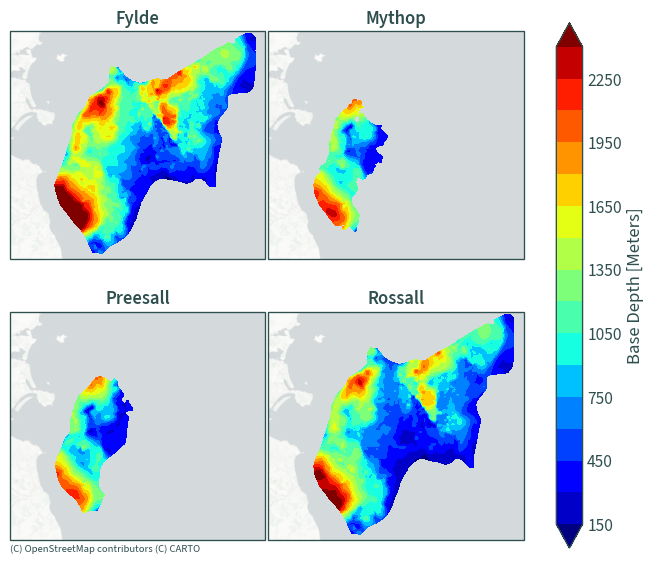

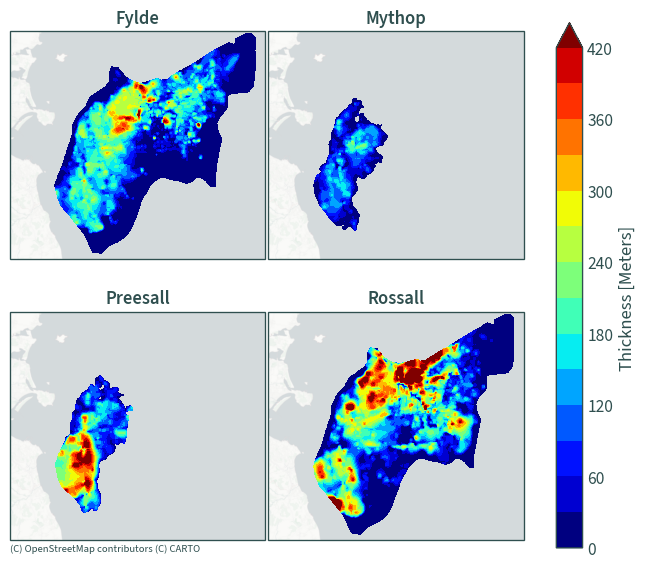

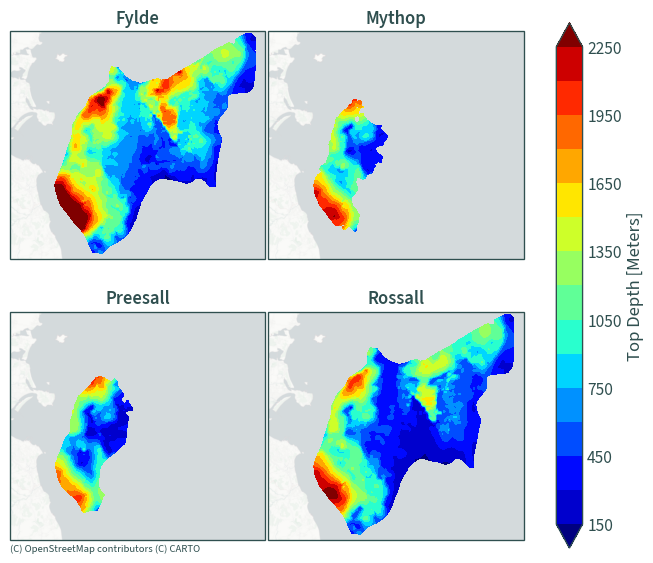

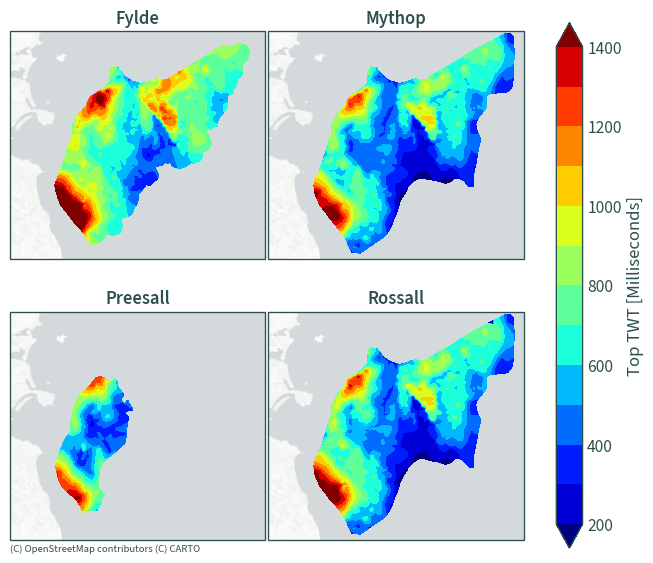

In [9]:
plot_facet_maps(ds, extent, CRS)

## Stats

In [5]:
def make_stats_plots(dat_xr):
    """
    Statistical plots for the halite Xarray dataset

    Parameters
    ----------
    dat_xr : Xarray dataset of the halite data

    Returns
    -------
    - The dataset converted into a dataframe
    """

    # convert to dataframe
    dat_df = dat_xr.to_dataframe()[list(dat_xr.data_vars)]

    # pairwise comparison of variables
    sns.pairplot(
        dat_df.reset_index(), palette="flare", hue="halite",
        plot_kws={"alpha": .5}, vars=["Thickness", "TopDepth", "BaseDepth"]
    )
    plt.show()

    # histograms
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    sns.histplot(
        dat_df.reset_index(), x="Thickness", hue="halite", ax=axes[0],
        palette="rocket_r", multiple="fill", bins=100, legend=False
    )
    sns.histplot(
        dat_df.reset_index(), x="TopDepth", hue="halite", ax=axes[1],
        palette="rocket_r", multiple="fill", bins=100
    )
    plt.tight_layout()
    plt.show()

    # box plots
    fig, axes = plt.subplots(1, 3, figsize=(8, 4.5))
    sns.boxplot(
        dat_df.reset_index(), y="Thickness", hue="halite", palette="flare",
        ax=axes[0]
    )
    sns.boxplot(
        dat_df.reset_index(), y="TopDepth", hue="halite", palette="flare",
        ax=axes[1], legend=False
    )
    sns.boxplot(
        dat_df.reset_index(), y="BaseDepth", hue="halite", palette="flare",
        ax=axes[2], legend=False
    )
    plt.tight_layout()
    plt.show()

    return dat_df

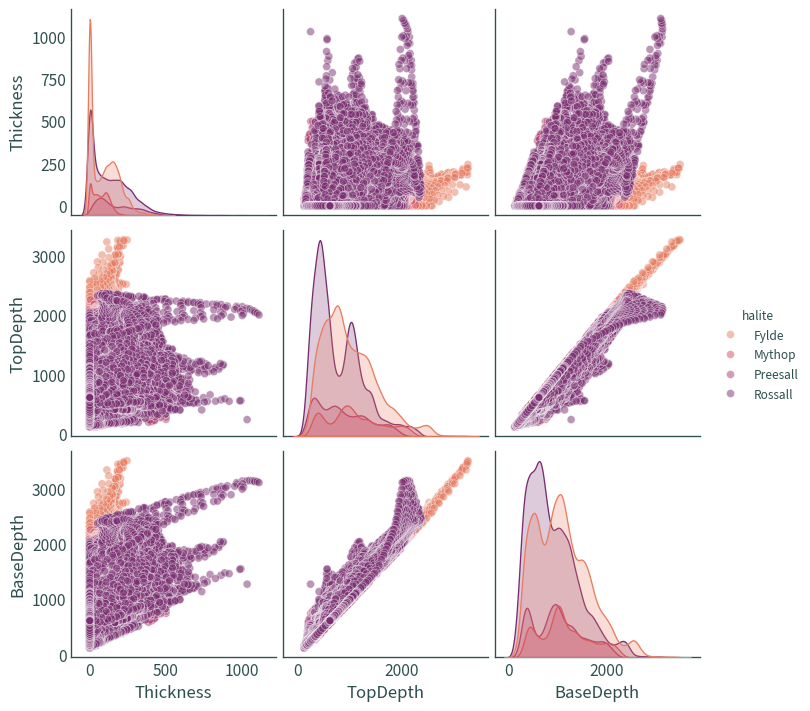

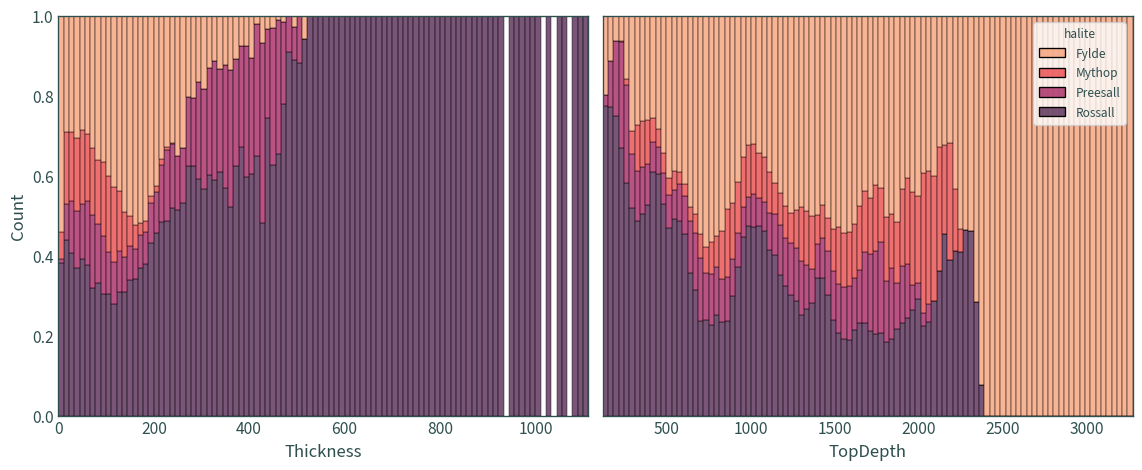

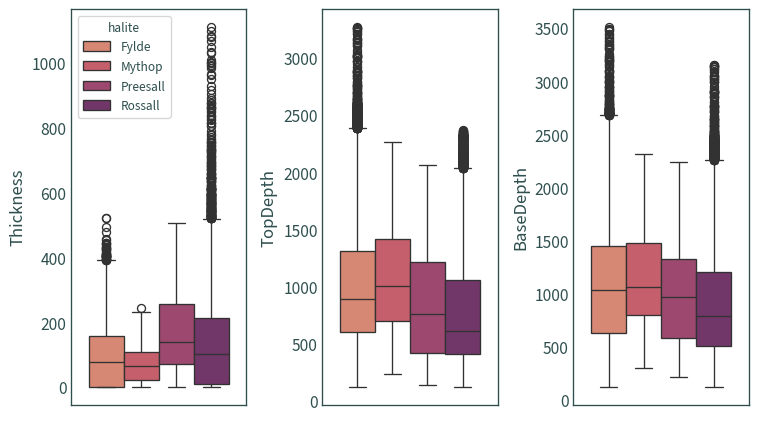

In [6]:
df = make_stats_plots(ds)

In [12]:
df.describe()

,BaseDepth,Thickness,TopDepth,TopTWT
count,63868.000000,63456.000000,63868.000000,80386.000000
mean,1011.301702,112.835875,899.392295,653.242487
std,536.478279,113.380006,507.401263,259.464713
min,120.324500,0.000000,120.324500,136.616000
25%,574.370900,4.344600,476.546675,468.859575
50%,952.930250,90.634850,818.911100,631.917300
75%,1334.956375,178.472675,1207.349725,776.623200
max,3512.489700,1111.067000,3273.030800,1911.048300


In [6]:
# surface area
shape = fns.halite_shape(ds, CRS)

In [48]:
f"Surface area: {shape.area[0]:.2E} m\N{SUPERSCRIPT TWO}"

'Surface area: 1.02E+09 m²'

In [7]:
def plot_facet_maps_distr(dat_xr, dat_extent, dat_crs, v, levels):
    """
    Helper function to plot facet maps of the halite layers

    Parameters
    ----------
    dat_xr : Xarray dataset of the halite data
    dat_extent : extent of the data
    dat_crs : EPSG CRS
    """

    xmin_, ymin_, xmax_, ymax_ = dat_extent.total_bounds

    f = dat_xr[v].plot.contourf(
        col="halite",
        robust=True,
        levels=levels,
        cmap=sns.color_palette("flare", as_cmap=True),
        # col_wrap=2,
        figsize=(12, 6),
        subplot_kws={"projection": ccrs.epsg(dat_crs)},
        xlim=(xmin_, xmax_),
        ylim=(ymin_, ymax_),
        cbar_kwargs={
            "location": "bottom", "aspect": 35, "shrink": 0.65, "pad": 0.05,
            "extendfrac": 0.2, "label": dat_xr[v].attrs["long_name"] + " [m]",
        },
    )
    # add a basemap
    basemap = cx.providers.CartoDB.PositronNoLabels
    for n, axis in enumerate(f.axs.flat):
        cx.add_basemap(
            axis, crs=dat_crs, source=basemap, attribution=False
        )
        # add attribution for basemap tiles
        if n == 0:
            axis.text(
                xmin_, ymin_ - 2500, basemap["attribution"], fontsize=8
            )
    f.set_titles("{value}", weight="semibold")
    plt.show()

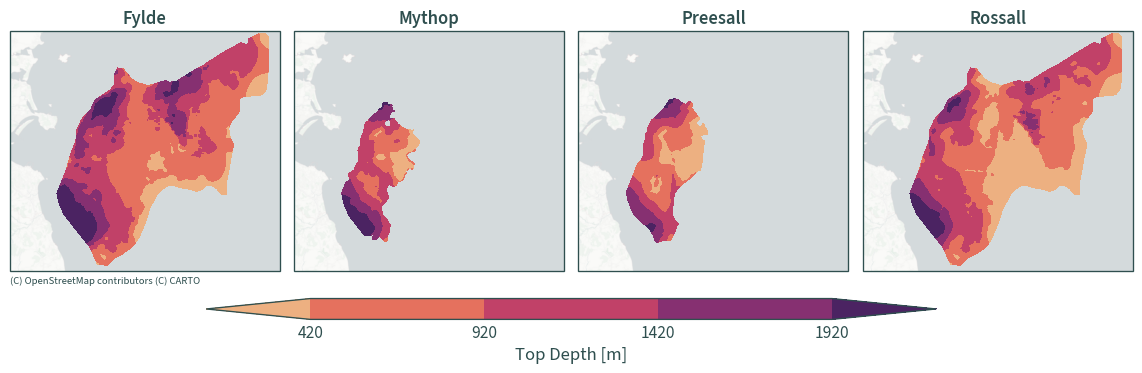

In [8]:
plot_facet_maps_distr(
    ds, extent, CRS, "TopDepth", [500 - 80, 1000 - 80, 1500 - 80, 2000 - 80]
)

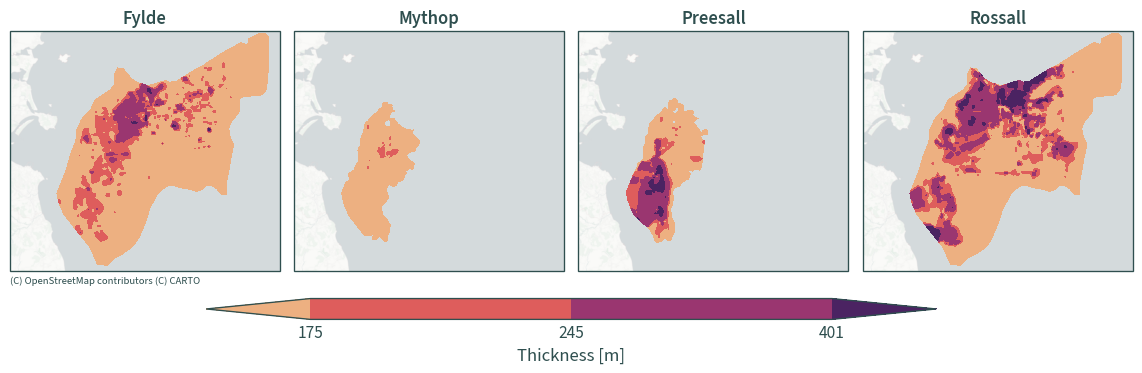

In [9]:
plot_facet_maps_distr(
    ds, extent, CRS, "Thickness", [85 + 90, 155 + 90, 311 + 90]
)

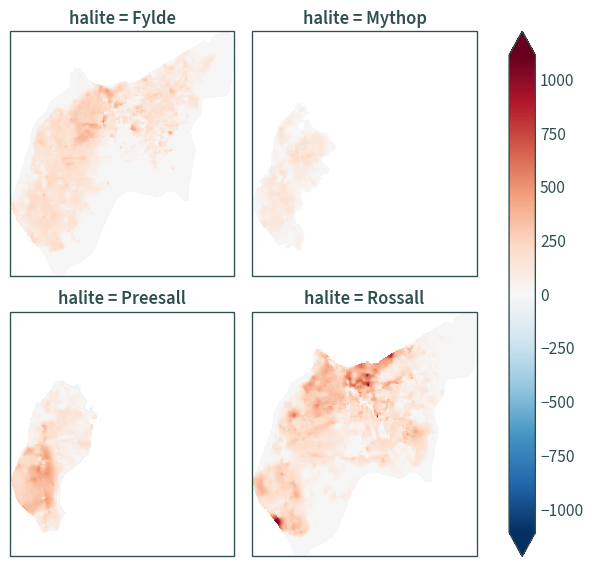

In [88]:
# compare depths
(ds["BaseDepth"] - ds["TopDepth"]).plot(
    col="halite", col_wrap=2, extend="both",
    subplot_kws={"projection": ccrs.epsg(CRS)},
)
plt.show()

In [14]:
min(set((ds["BaseDepth"] - ds["TopDepth"]).values.flatten()))

-53.5

In [15]:
max(set((ds["BaseDepth"] - ds["TopDepth"]).values.flatten()))

1111.0679

## Zones of interest

In [8]:
def plot_zones_map(zdf, dat_extent, dat_crs):

    xmin_, ymin_, xmax_, ymax_ = dat_extent.total_bounds

    ax = plt.axes(projection=ccrs.epsg(dat_crs))
    zdf.boundary.plot(ax=ax, linewidth=1, color="darkslategrey")
    plt.xlim(xmin_, xmax_)
    plt.ylim(ymin_, ymax_)
    cx.add_basemap(
        ax, source=cx.providers.CartoDB.PositronNoLabels, crs=dat_crs
    )
    plt.title("Zones of interest")
    plt.tight_layout()
    plt.show()

### Case 1

height = 311 m, 1,000 m <= depth <= 1,500 m, diameter = 80 m,
separation = 320 m

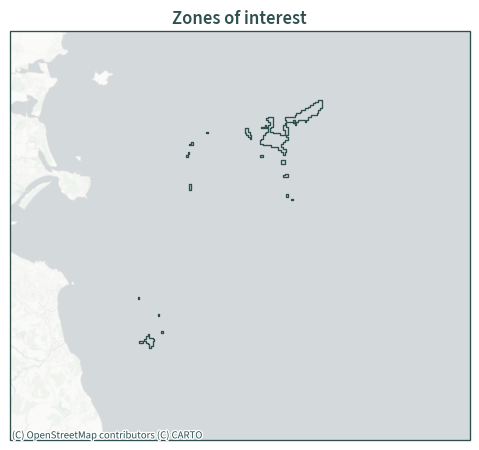

In [9]:
zones_1, zds_1 = fns.zones_of_interest(
    ds, CRS, {"height": 311, "min_depth": 1000, "max_depth": 1500}
)

plot_zones_map(zones_1, extent, CRS)

### Case 2

height = 155 m, 1000 m <= depth <= 1,500 m, diameter = 80 m,
separation = 320 m

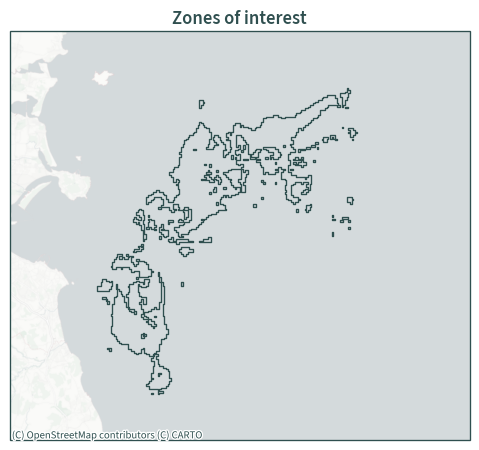

In [26]:
zones_2, zds_2 = fns.zones_of_interest(
    ds, CRS, {"height": 155, "min_depth": 750, "max_depth": 1750}
)

plot_zones_map(zones_2, extent, CRS)

### Case 3

height = 85 m, 500 m <= depth <= 2,000 m, diameter = 80 m,
separation = 320 m

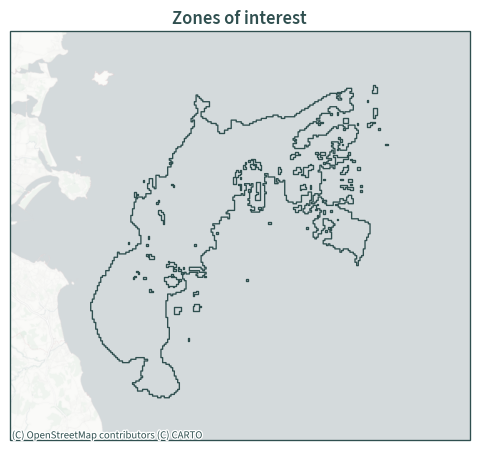

In [11]:
zones_3, zds_3 = fns.zones_of_interest(
    ds, CRS, {"height": 85, "min_depth": 500, "max_depth": 2000}
)

plot_zones_map(zones_3, extent, CRS)

## Zones of interest stats

### Case 1

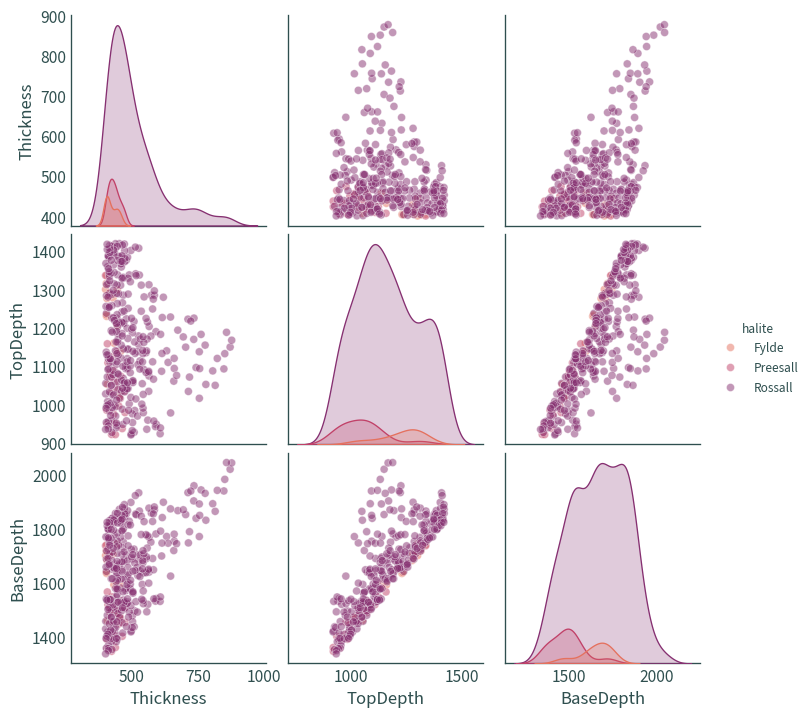

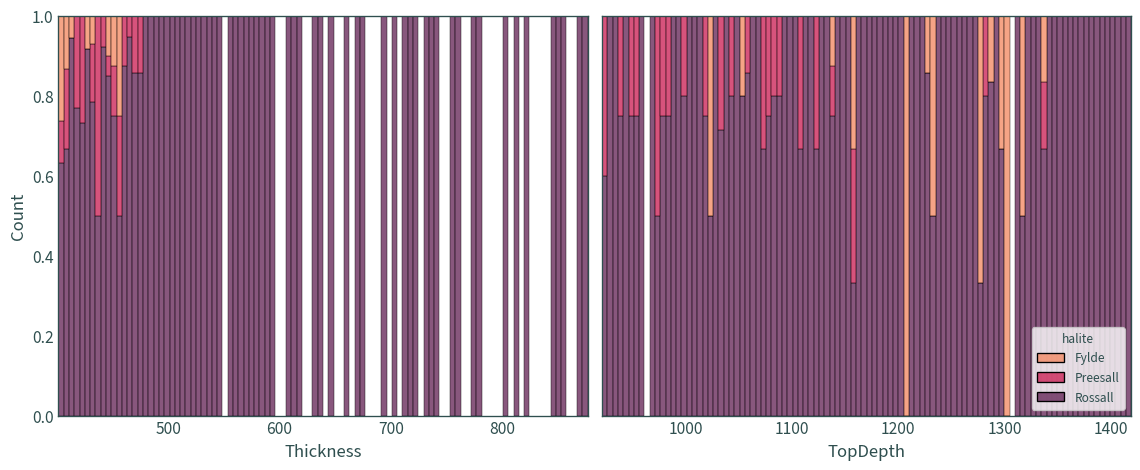

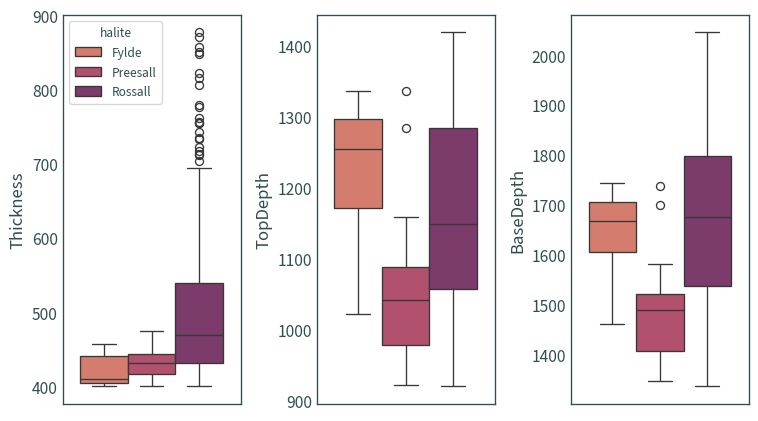

In [12]:
zdf_1 = make_stats_plots(zds_1)

In [13]:
zdf_1.describe()

,BaseDepth,Thickness,TopDepth,TopTWT
count,338.000000,338.000000,338.000000,338.000000
mean,1654.427353,493.756757,1160.670600,755.394412
std,159.373522,97.618458,139.679649,87.442703
min,1336.660500,401.074500,921.214100,577.705400
25%,1527.275750,426.237650,1053.219700,687.781000
50%,1655.889400,463.288650,1140.403900,740.526000
75%,1780.224975,526.028750,1280.124775,819.406525
max,2045.991200,877.043200,1419.385400,1004.849900


### Case 2

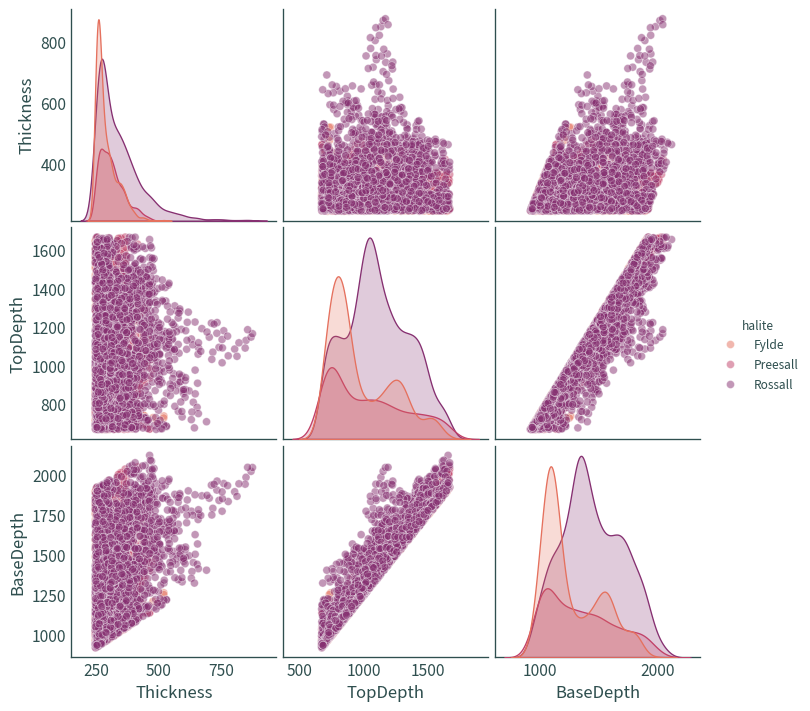

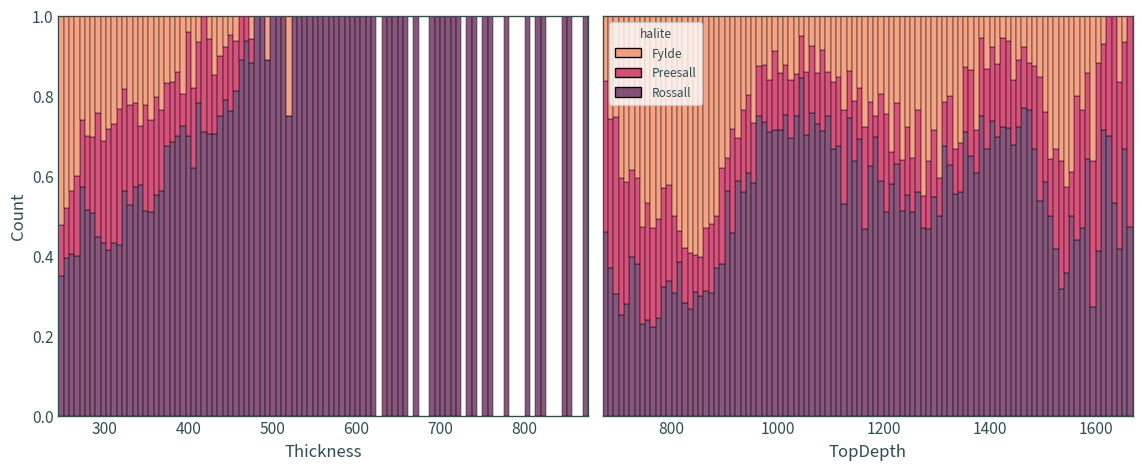

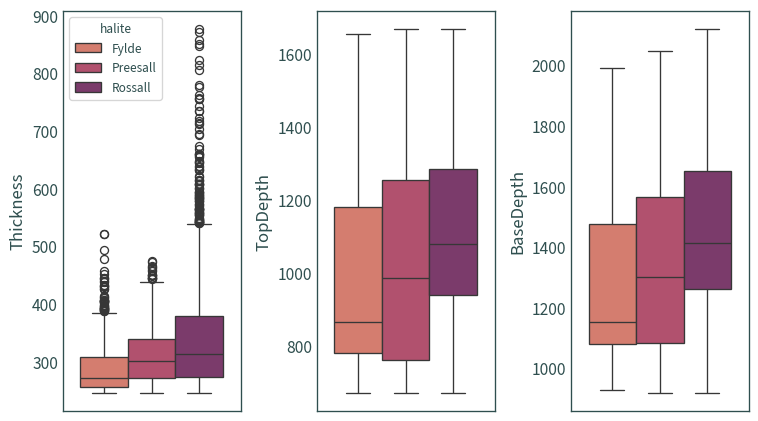

In [42]:
zdf_2 = make_stats_plots(zds_2)

In [43]:
zdf_2.describe()

,BaseDepth,Thickness,TopDepth,TopTWT
count,4667.000000,4667.000000,4667.000000,4667.000000
mean,1373.357567,319.519216,1053.838351,745.909768
std,273.632783,77.467851,261.083039,140.226790
min,917.408200,245.000700,670.007900,483.358300
25%,1126.586700,265.105850,822.546600,639.855550
50%,1345.397900,295.233500,1030.095200,716.723000
75%,1582.502700,350.390050,1249.613400,841.922800
max,2120.831300,877.043200,1669.802700,1215.366000


### Case 3

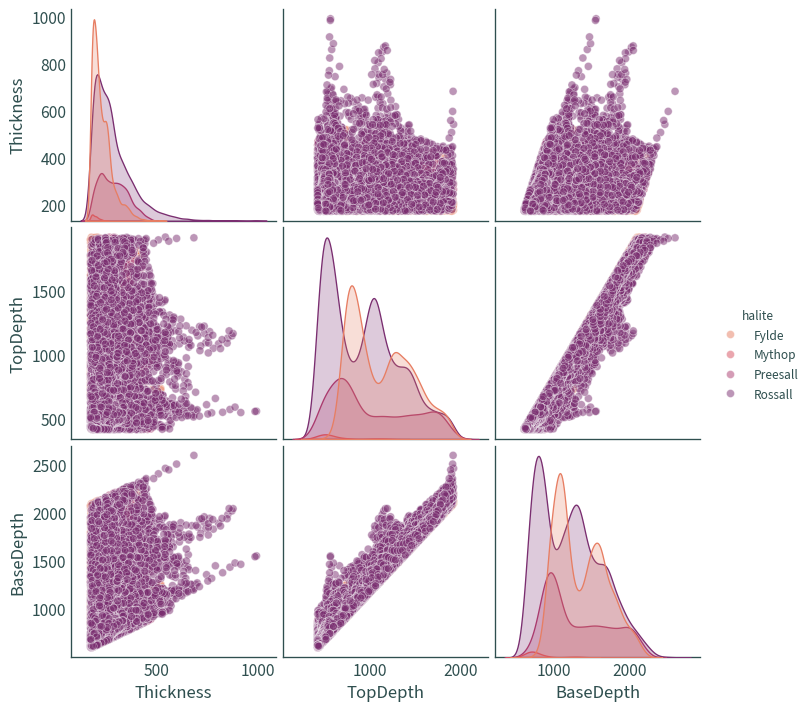

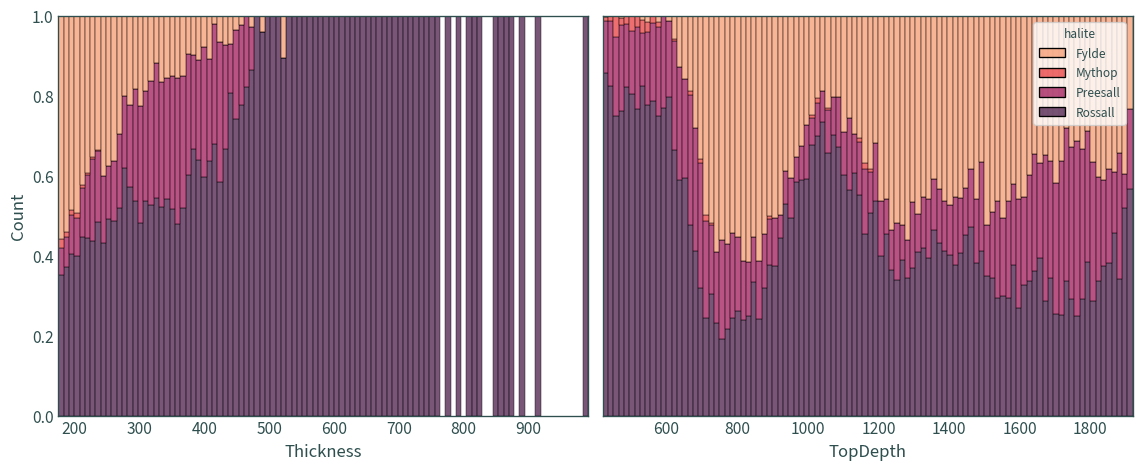

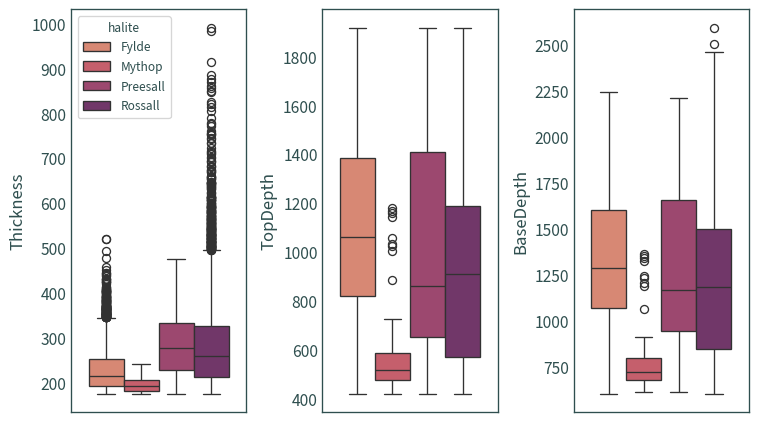

In [16]:
zdf_3 = make_stats_plots(zds_3)

In [17]:
zdf_3.describe()

,BaseDepth,Thickness,TopDepth,TopTWT
count,13986.000000,13986.000000,13986.000000,13986.000000
mean,1271.132266,266.343353,1004.788911,733.848272
std,389.465054,83.571234,391.114242,196.134638
min,600.344600,175.012400,420.019200,342.013500
25%,954.374150,204.783700,685.046525,585.012125
50%,1210.942850,245.009400,951.199750,695.677150
75%,1570.800200,303.511700,1303.768575,860.545875
max,2598.191400,992.179400,1919.885000,1395.455100


## Sensitivity analysis

Sensitivity of maximum halite area (i.e. zones of interest) available for
cavern construction (without constraints) to depth and thickness

In [34]:
def sensitivity(zones_gdf, height_base, min_depth_base, max_depth_base):

    sdf = {}

    # sensitivity to height
    heights = [85 + 226 / 50 * n for n in range(51)]
    area_max = []

    for t in heights:
        area_max.append(
            fns.zones_of_interest(
                ds, CRS,
                {
                    "height": t, "min_depth": min_depth_base,
                    "max_depth": max_depth_base
                }
            )[0].area[0]
        )

    sdf["height"] = pd.DataFrame({"max_area": area_max, "height": heights})

    # percentage change
    sdf["height"]["diff_area"] = (
        (
            sdf["height"]["max_area"] - zones_gdf.area[0]
        ) / zones_gdf.area[0] * 100
    )

    # sensitivity to minimum depth
    depth_min = [500 + 10 * n for n in range(61)]
    area_max = []

    for t in depth_min:
        area_max.append(
            fns.zones_of_interest(
                ds, CRS,
                {
                    "height": height_base, "min_depth": t,
                    "max_depth": max_depth_base
                }
            )[0].area[0]
        )

    sdf["min_depth"] = pd.DataFrame(
        {"max_area": area_max, "min_depth": depth_min}
    )

    # percentage change
    sdf["min_depth"]["diff_area"] = (
        (
            sdf["min_depth"]["max_area"] - zones_gdf.area[0]
        ) / zones_gdf.area[0] * 100
    )

    # sensitivity to maximum depth
    depth_max = [1400 + 10 * n for n in range(61)]
    area_max = []

    for t in depth_max:
        area_max.append(
            fns.zones_of_interest(
                ds, CRS,
                {
                    "height": height_base, "min_depth": min_depth_base,
                    "max_depth": t
                }
            )[0].area[0]
        )

    sdf["max_depth"] = pd.DataFrame(
        {"max_area": area_max, "max_depth": depth_max}
    )

    # percentage change
    sdf["max_depth"]["diff_area"] = (
        (
            sdf["max_depth"]["max_area"] - zones_gdf.area[0]
        ) / zones_gdf.area[0] * 100
    )

    return sdf

In [35]:
sdf = sensitivity(zones_2, 155, 750, 1750)

In [36]:
for key in sdf.keys():
    print(key)
    print(sdf[key].describe())

height
           max_area      height  diff_area
count  5.100000e+01   51.000000  51.000000
mean   1.293710e+08  198.000000 -26.610517
std    9.212775e+07   67.194631  52.262169
min    2.212000e+07   85.000000 -87.451781
25%    5.036000e+07  141.500000 -71.431813
50%    1.001600e+08  198.000000 -43.181302
75%    2.034800e+08  254.500000  15.429998
max    3.187200e+08  311.000000  80.803268
min_depth
           max_area   min_depth  diff_area
count  6.100000e+01    61.00000  61.000000
mean   1.615377e+08   800.00000  -8.362999
std    4.254186e+07   177.52934  24.133115
min    9.332000e+07   500.00000 -47.061493
25%    1.213600e+08   650.00000 -31.154981
50%    1.629200e+08   800.00000  -7.578852
75%    1.983200e+08   950.00000  12.502836
max    2.326000e+08  1100.00000  31.949172
max_depth
           max_area   max_depth  diff_area
count  6.100000e+01    61.00000  61.000000
mean   1.727089e+08  1700.00000  -2.025838
std    1.224146e+07   177.52934   6.944328
min    1.468800e+08  1400.0

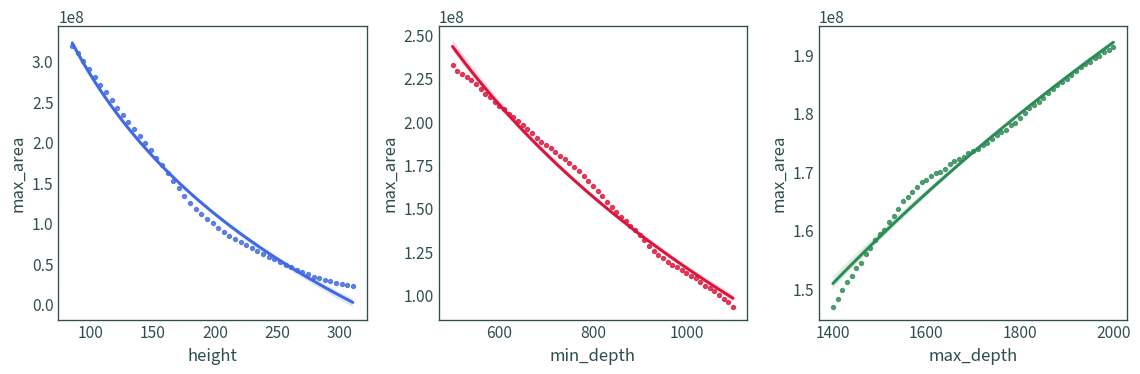

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for (n, key), c in zip(
    enumerate(sdf.keys()), ["royalblue", "crimson", "seagreen"]
):
    sns.regplot(
        sdf[key], x=key, y="max_area", logx=True, ax=axes[n],
        marker=".", color=c
    )
plt.tight_layout()
plt.show()

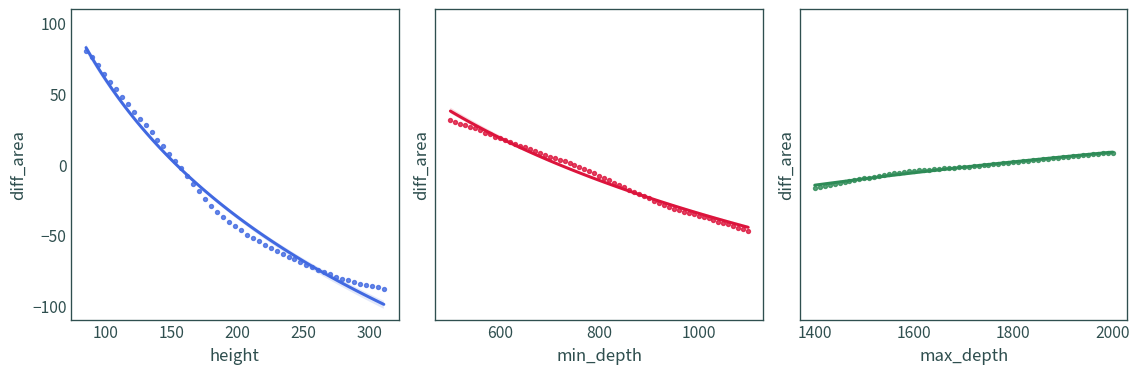

In [41]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
for (n, key), c in zip(
    enumerate(sdf.keys()), ["royalblue", "crimson", "seagreen"]
):
    sns.regplot(
        sdf[key], x=key, y="diff_area", logx=True, ax=axes[n],
        marker=".", color=c
    )
plt.ylim(-110, 110)
plt.tight_layout()
plt.show()